In [20]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")

import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve, fitting
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp
import utils.utils as ut
# import lc
import os
import utils.analysis as an
torch.set_default_dtype(torch.float64)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# lc_dir = os.path.join("../data/2022acko", "2022acko_total.dat")
# lc = load_lc(lc_dir=lc_dir)
# lc.calcAbsMag()
# lc.calcLum()
# # light_curve_plot(lc, ycol="lum")

In [6]:
all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"][::-1]  # from red to UV
mjd_array = np.linspace(3, 13, 600)


filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

max_days = 5
time_spans = np.arange(1, max_days + 1)  # [1, 2, ..., 10]

model_parameters = [1.2, 2.,2., 4.0, 2.5]

# --- setup light curve builder ---
builder = ut.LCBuilder(
    model_name="sc4",
    model_parameters=model_parameters,
    model_units=[1,1,1,1,1],
    seed=42
)

lc = builder.build_sim_lc(
    mjd_array=mjd_array,
    filters_list=all_filters,  # full set
    redshift=0.00526,
    dlum_factor=1e-1/2,
    dm=31.1,
    dL=19.,
    dLerr=2.9
)

In [7]:
t_span = 10
min_mjd = lc['MJD'].min()

lc_early = lc.where(MJD_min=min_mjd-1, MJD_max=min_mjd+t_span) 

model = models.ModifiedShockCooling4(lc_early)


ten13cmtoRsol = 1e13*1.4374e-11 
ten8p5cmstoten3kms = 10**.5
# units_array = np.array([ten8p5cmstoten3kms, 1, 1, ten13cmtoRsol, 1, 1]).reshape(1,-1)

priors = [
models.UniformPrior(0, 10),
models.UniformPrior(0, 10),
models.UniformPrior(0, 10),
models.UniformPrior(0, 100),
models.UniformPrior(min_mjd-4, min_mjd+5),
models.LogUniformPrior(0,1e2),
]

p_lo = [0.5, 0.5,  0.5, 1, min_mjd-2, 6]
p_up = [3, 4,  4, 6, min_mjd+2, 8]

N_WALKERS = 32
N_STEPS = 8000
N_STEPS_BURNIN = 1 
# sampler = fitting.lightcurve_mcmc(lc_early, model, 
#                                 priors=priors, p_lo=p_lo, p_up=p_up,
#                                 nwalkers=N_WALKERS, nsteps=N_STEPS, nsteps_burnin=N_STEPS_BURNIN, use_sigma=True)


save_dir = os.path.join(ut.storage_parent_path, "experiments", "mcmc")
os.makedirs(save_dir, exist_ok=True)
# np.save(os.path.join(save_dir, "flatchain_mcmc_10d_all_filters.npy"), np.array(sampler.flatchain))



In [10]:
sc4_flatchain = np.load(os.path.join(save_dir, "flatchain_mcmc_10d_all_filters.npy"))#'outputs/flatchain_sc4_full_lc_neuripsprior.npy')*units_array#[:,:]

nparams = sc4_flatchain.shape[-1]
nwalkers = 40
nsteps = N_STEPS
sc4_walker_chain = np.zeros((nwalkers, nsteps, nparams)).astype('float32')

for i in range(nwalkers):
    
    sc4_walker_aux = sc4_flatchain[i::nwalkers]
    sc4_walker_chain[i] = sc4_walker_aux

nburnin =  1
sc4_walker_chain = sc4_walker_chain[:,nburnin:,:]


In [11]:
def outside_bound_idx(arr, plow=16, pupp=84, get_complement=False):

    lowerlim = np.percentile(arr, plow)
    upperlim = np.percentile(arr, pupp)
    
    mask = (arr>=lowerlim)*(arr<=upperlim)
    idxs_in = np.arange(len(arr))[mask]
    idxs_out = np.arange(len(arr))[~mask]
    if get_complement:
        return idxs_out, idxs_in
    else:
        return idxs_out

In [12]:
import astropy.units as u
use_sigma = True

model = models.ModifiedShockCooling4(lc)
# if use_sigma and model.input_names[-1] != '\\sigma':
#     model.input_names.append('\\sigma')
#     model.units.append(u.dimensionless_unscaled)

# model.units[3] = u.Rsun
# model.units[0] = 10**3*u.km/u.s
axis_labels_corner = model.axis_labels
axis_labels_corner.append('$\\sigma$')

Text(0.5, 0, 'steps')

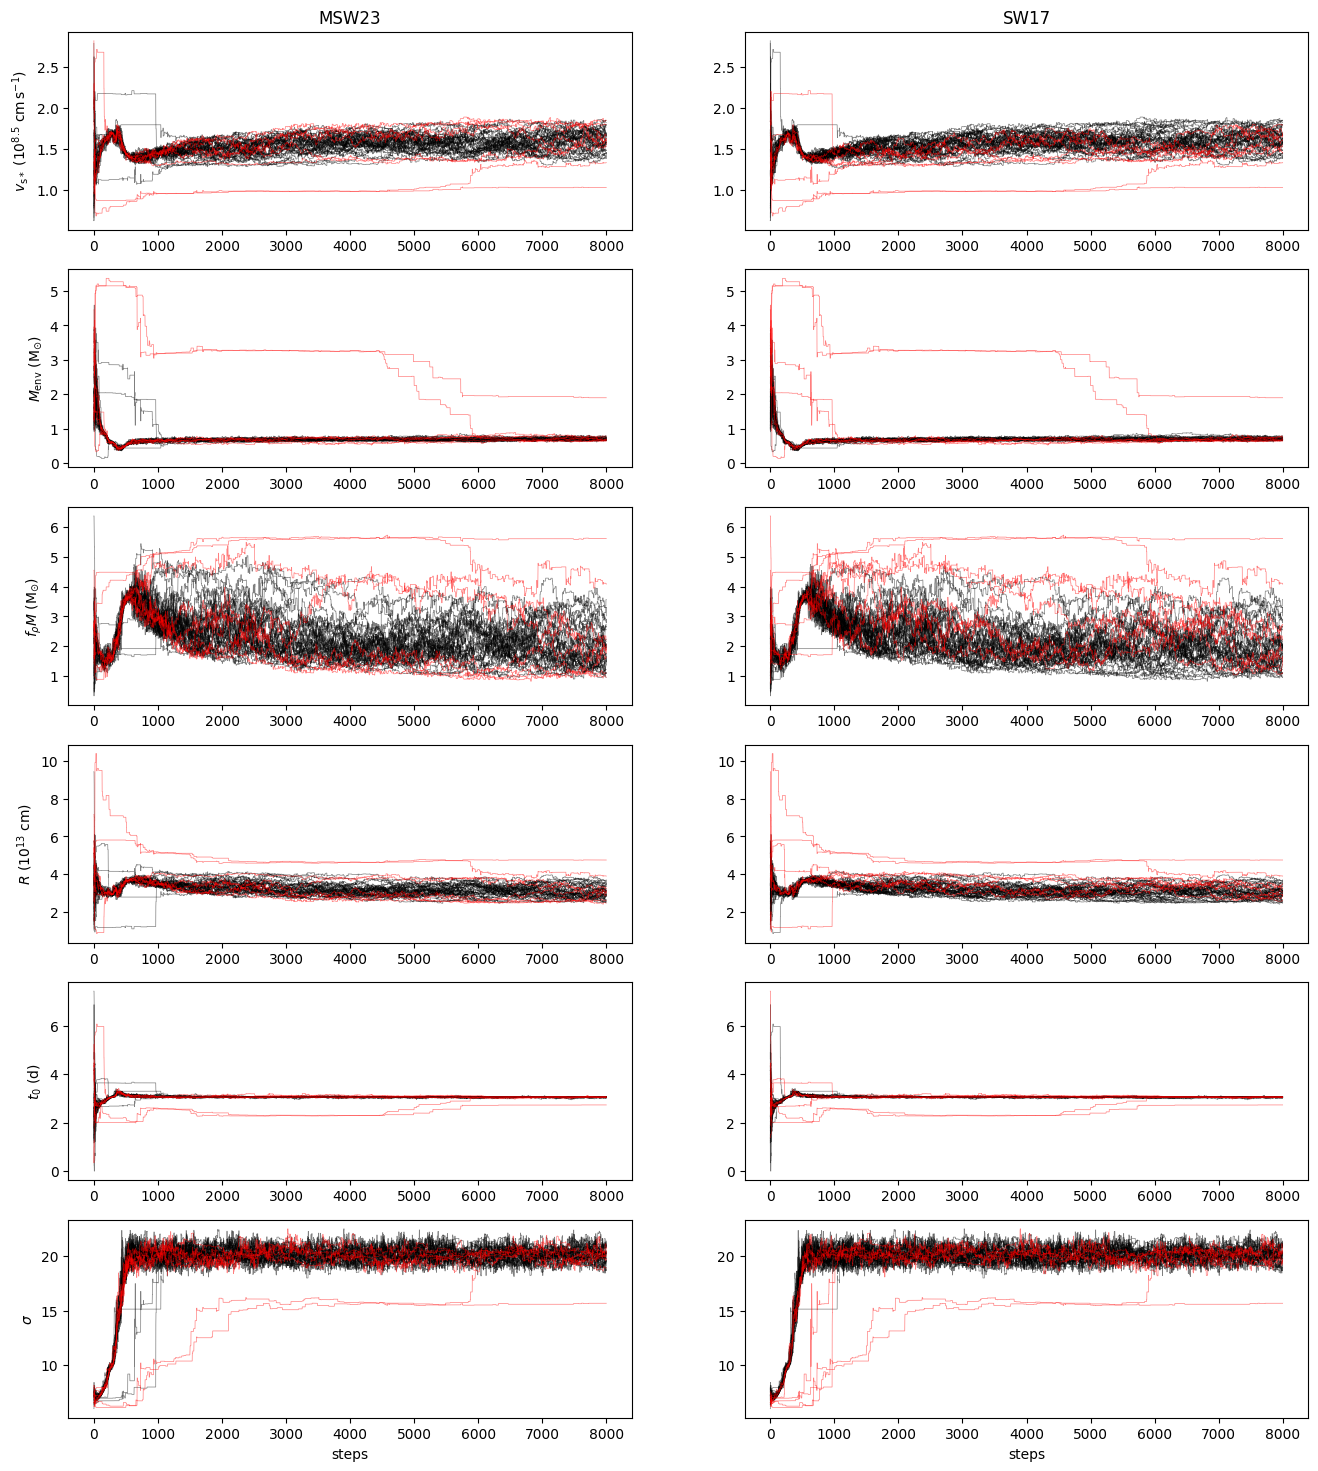

In [13]:
sc3_walker_chain = sc4_walker_chain
plt.rcdefaults()
fig, axes = plt.subplots(figsize=(16, 3*nparams), nrows=nparams, ncols=2)


iterations = np.arange(nsteps-nburnin)

axes[0,0].set_title('MSW23')
axes[0,1].set_title('SW17')



pfit_sc4_param = sc4_walker_chain[:,:,2].T
last_points_param_sc4 = np.mean(pfit_sc4_param[:], axis=0)

idxs_out_sc4, idxs_in_sc4 = outside_bound_idx(last_points_param_sc4, plow=10, pupp=90, get_complement=True)

pfit_sc3_param = sc3_walker_chain[:,:,1].T
last_points_param_sc3 = np.mean(pfit_sc3_param[:], axis=0)

idxs_out_sc3, idxs_in_sc3 = outside_bound_idx(last_points_param_sc3, plow=10, pupp=90, get_complement=True)

for i in range(nparams):
    ax_sc4 = axes[i, 0]
    ax_sc3 = axes[i, 1]
    
    pfit_sc4 = sc4_walker_chain[:,:,i].T
    pfit_sc3 = sc3_walker_chain[:,:,i].T
    
    ax_sc4.plot(iterations, pfit_sc4[:, idxs_in_sc4], c='black', lw=.5, alpha=.5)
    ax_sc4.plot(iterations, pfit_sc4[:, idxs_out_sc4], c='red', lw=.5, alpha=.5)
    
    ax_sc3.plot(iterations, pfit_sc3[:, idxs_in_sc3], c='black', lw=.5, alpha=.5)
    ax_sc3.plot(iterations, pfit_sc3[:, idxs_out_sc3], c='red', lw=.5, alpha=.5)

    ax_sc4.set_ylabel(axis_labels_corner[i])
ax_sc4.set_xlabel('steps')
ax_sc3.set_xlabel('steps')

In [ ]:
sc4_flatchain.shape

(128000, 6)

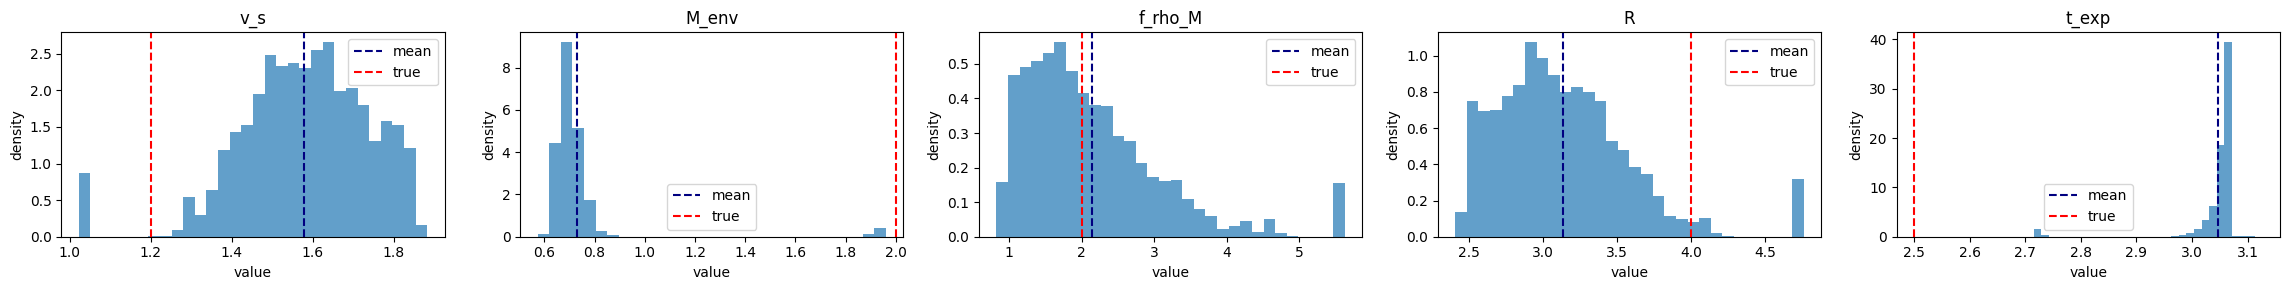

In [17]:
samples = sc4_flatchain[-2000*nwalkers:, :-1]
param_names = ["v_s", "M_env",  "f_rho_M", "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = builder.model_parameters
# new_true = np.zeros(len(true)+1)
# new_true[:2] = true[:2]
# new_true[-2:] = true[-2:]
# new_true[2] = true[1]
# true = new_true
fig, axes = plt.subplots(1, 5, figsize=(23, 3))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")


    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()

/tf/ProjectGabriel/pilca/utils/analysis.py:68: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t_grid, np.log10(mod_vals.squeeze()) + offsets[filt], color=filtstyle["color"], alpha=0.05, zorder=0)


/tf/ProjectGabriel/pilca/utils/analysis.py:76: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t_grid, np.log10(mod_vals.squeeze()) + offsets[filt], lw=2, label=f"Median model - {filt}", c=filtstyle["color"])


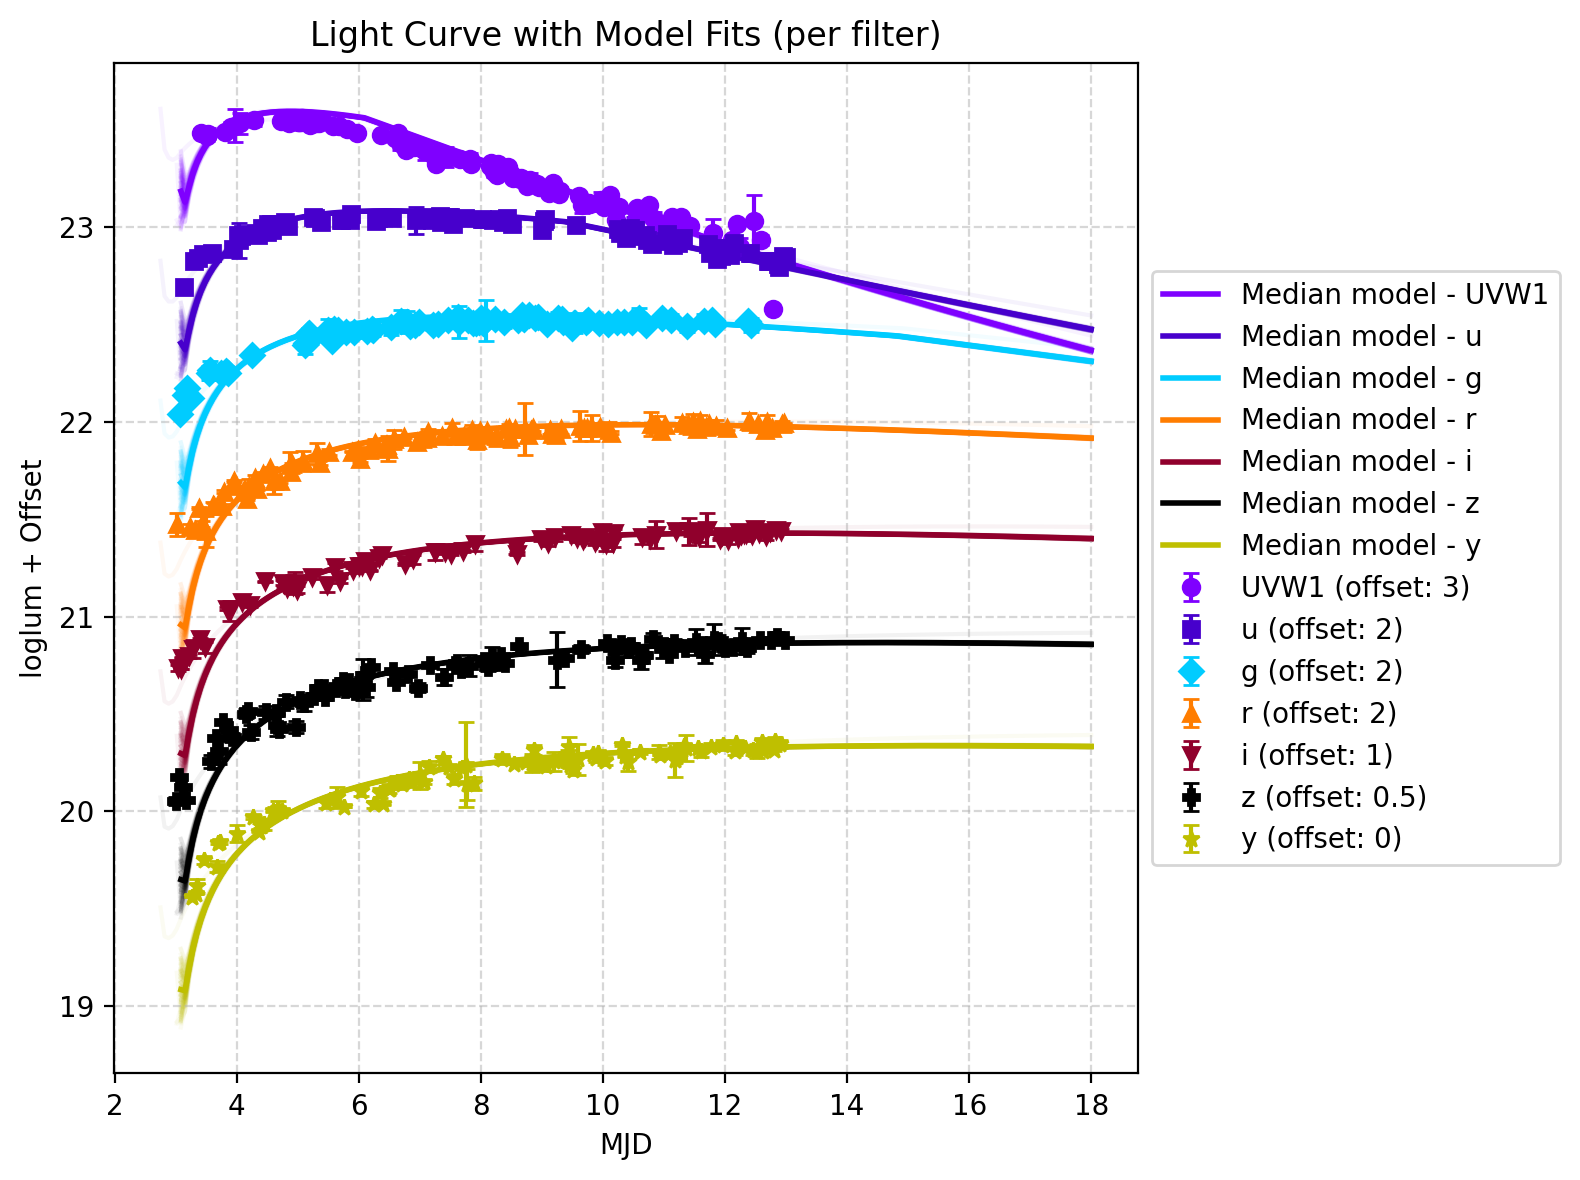

In [21]:
model = models.ModifiedShockCooling4(lc)
an.lc_modeling_plot(lc=lc, samples=samples, model=model, ycol="loglum")